In [1]:
from scipy.stats import multivariate_normal
import chipwhisperer as cw
import numpy as np

In [2]:
# The AES SBox that we will use to generate our labels
AES_Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])
# The Hamming weight list of each byte value
hw_list = np.array([
            0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
            3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8
            ])
# Number of combinations for each Hamming weight
hw_combinations = np.array([1, 8, 28, 56, 70, 56, 28, 8, 1])

In [3]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'
CRYPTO_TARGET = 'TINYAES128C'
VERSION = 'HARDWARE'
SS_VER = 'SS_VER_1_1'

trace_num = 30000  # Number of traces

project_file_name = f"traces/CWNANO_{CRYPTO_TARGET}_{trace_num}_randkey.cwp"
print(f'Reading {project_file_name}...')
proj = cw.open_project(project_file_name)

t = np.array(proj.waves)
p = np.array(proj.textins)
k = np.array(proj.keys)
c = np.array(proj.textouts)

num_traces = t.shape[0]
trace_length = t.shape[1]
print(f'Number of traces = {num_traces}, trace length = {trace_length}')

Reading traces/CWNANO_TINYAES128C_30000_randkey.cwp...
Number of traces = 30000, trace length = 5000


In [4]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'
CRYPTO_TARGET = 'TINYAES128C'
VERSION = 'HARDWARE'
SS_VER = 'SS_VER_1_1'

trace_num = 30000  # Number of traces

project_file_name = f"traces/CWNANO_{CRYPTO_TARGET}_{trace_num}_fixedkey.cwp"
print(f'Reading {project_file_name}...')
proj = cw.open_project(project_file_name)

attack_t = np.array(proj.waves)
attack_p = np.array(proj.textins)
attack_k = np.array(proj.keys)
attack_c = np.array(proj.textouts)

num_traces = t.shape[0]
trace_length = t.shape[1]
print(f'Number of traces = {num_traces}, trace length = {trace_length}')

Reading traces/CWNANO_TINYAES128C_30000_fixedkey.cwp...
Number of traces = 30000, trace length = 5000


In [5]:
print(t.shape)
print(p.shape)
print(k.shape)
print(c.shape)

(30000, 5000)
(30000, 16)
(30000, 16)
(30000, 16)


In [6]:
print(p[0][0])
print(k[0][0])
target = hw_list[AES_Sbox[p ^ k]]

34
43


In [7]:
group_count = np.zeros((16, 9), dtype=np.uint32)
t_sum = np.zeros((16, 9, trace_length))
t_sum2 = np.zeros((16, 9, trace_length))

for i in range(trace_num):
    for b in range(16):
        h = target[i][b]
        t_sum[b][h] +=t[i]
        t_sum2[b][h] +=t[i] ** 2
        group_count[b][h] += 1

In [8]:
print(group_count[0].reshape(9, 1))
print(t_sum[0].shape)

[[ 111]
 [ 962]
 [3221]
 [6569]
 [8188]
 [6680]
 [3233]
 [ 946]
 [  90]]
(9, 5000)


In [9]:
signal = np.zeros((16, trace_length))
noise = np.zeros((16, trace_length))

for b in range(16):
    divisor = group_count[b].reshape(9, 1)
    mean_trace = t_sum[b] / divisor
    var_trace = t_sum2[b] / divisor - mean_trace ** 2
    
    mean_sum2 = np.zeros((1, trace_length))
        
    for i in range(9):
        mean_sum2 += mean_trace[i] ** 2 * group_count[b, i]
        
    signal[b] = mean_sum2 / trace_num - (np.sum(t_sum[b], 0) / trace_num) ** 2
    noise[b] = np.average(var_trace, axis=0, weights=group_count[b].flatten())
    
snr = signal / noise

<function matplotlib.pyplot.show(close=None, block=None)>

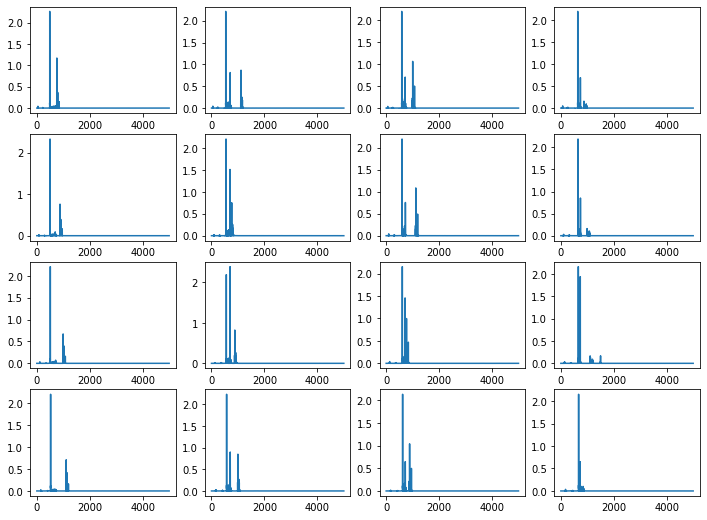

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))

for j in range(16):
    plt.subplot(4, 4, j + 1)
    plt.plot(snr[j][:5000].T)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

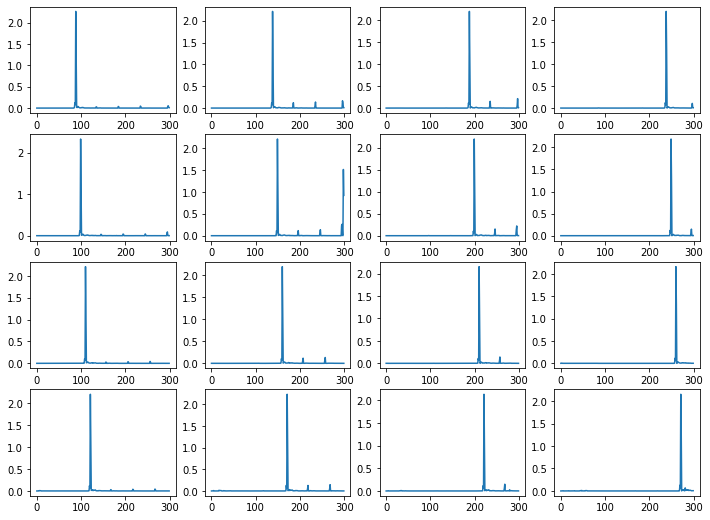

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))

for j in range(16):
    plt.subplot(4, 4, j + 1)
    plt.plot(snr[j][400:700].T)

plt.show

In [12]:
target = hw_list[AES_Sbox[p ^ k]]
poi_index = np.argsort(snr, axis=1)[:,-10:]

for b in range(16):
    poi = t[:, poi_index[b]]
    m = np.zeros((9, 10))
    cov = np.zeros((9, 10, 10))
    for i in range(9):
        g = poi[target[:, b] == i, :]
        m[i] = np.mean(g, axis=0)
        cov[i] = np.cov(g, rowvar=0)
    
    attack_poi = attack_t[:, poi_index[b]]
    hw_log_prob = np.zeros(9)
    key_log_prob = np.zeros(256)
    
    for i in range(100):
        for j in range(9):

            hw_log_prob[j] = np.log(multivariate_normal.pdf(attack_poi[i], mean=m[j], cov=cov[j]) / hw_combinations[j] + 1e-40)
            
        key_log_prob += hw_log_prob[hw_list[AES_Sbox[np.arange(256)^attack_p[i, b]]]]

print(key_log_prob)

[-8854.75689041 -8841.29405162 -8746.38112104 -8811.66243872
 -8786.72330714 -8850.31206583 -8816.85653172 -8839.69768212
 -8818.86993672 -8784.34216737 -8845.69841287 -8808.48073827
 -8813.65773615 -8832.76898188 -8796.8412576  -8753.88039497
 -8886.9625335  -8817.88899259 -8776.36012249 -8793.50720783
 -8788.58010862 -8755.66892706 -8815.80428077 -8807.63944981
 -8769.66976217 -8787.43385594 -8792.24372039 -8865.68917799
 -8790.52450597 -8810.84937035 -8808.32878746 -8888.42868134
 -8844.6582749  -8852.59610454 -8788.84602138 -8800.66498377
 -8779.54279038 -8857.07409564 -8783.08004799 -8824.85759479
 -8842.05390636 -8795.45415227 -8821.12524965 -8795.68139251
 -8816.49087984 -8774.68261472 -8815.98390336 -8831.37224111
 -8787.01618735 -8742.79799174 -8816.27421643 -8835.95821969
 -8811.96003329 -8739.01331135 -8769.26160734 -8793.71143457
 -8756.19731854 -8793.25990609 -8790.69367335 -8743.2868496
 -8700.85727967 -8771.94918213 -8810.95830817 -8810.71736867
 -8761.13312393 -8843.563